In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# try running the following code, if you see errors on Windows OS
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [4]:
import pandas as pd
import numpy as np

# File to Load (Remember to Change These)
file_to_load = "data\PendulumData.csv"

# Read Purchasing File and store into Pandas data frame
pendulum_csv = pd.read_csv(file_to_load,header=None)
pendulum_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,...,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
1,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,...,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
2,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,...,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
3,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,...,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999
4,29.998,29.998,29.998,29.999,29.999,29.999,29.999,29.999,29.999,29.999,...,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999


In [5]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
pendulum_csv=mms.fit_transform(pendulum_csv.iloc[:])
pendulum_csv

array([[0.97673377, 0.97777956, 0.9786896 , ..., 0.99377518, 0.99393889,
        0.99408616],
       [0.97673377, 0.97777956, 0.9786896 , ..., 0.99377518, 0.99393889,
        0.99408616],
       [0.97673377, 0.97777956, 0.9786896 , ..., 0.99377518, 0.99393889,
        0.99408616],
       ...,
       [0.01776548, 0.2461711 , 0.55136801, ..., 0.37159699, 0.47960198,
        0.58019195],
       [0.0172378 , 0.24487344, 0.54995106, ..., 0.37080279, 0.47880264,
        0.57942547],
       [0.0167261 , 0.24357578, 0.54853411, ..., 0.37000859, 0.47800495,
        0.57865733]])

In [6]:
nm=11
nl=11
m0=1
l0=1
deltal=0.1
deltam=0.1
t=np.arange(0,5/5,0.001/5)
l_np=np.arange(l0-l0,nl*deltal/l0,deltal)
m_np=np.arange(m0-m0,nm*deltam/m0,deltam)

X=[]
Y=[]
for i in range(1,nl+1):
    for j in range(1,nm+1):
        preX=np.column_stack((t,l_np[i-1].repeat(len(t)),m_np[j-1].repeat(len(t))))
        X.append(preX)
        Y.append(pendulum_csv[:,nl*(i-1)+j-1])
X_array=np.array(X)
X=X_array.reshape(605000,3)
Y_array=np.array(Y)
Y=Y_array.reshape(605000,1)

In [7]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)
X.shape, Y.shape

(torch.Size([605000, 3]), torch.Size([605000, 1]))

In [8]:
#import random
#index = [i for i in range(len(Y))] 
#random.shuffle(index)
#X = X[index,:]
#Y = Y[index,:]

In [9]:
#N=-10000
#X_train, X_test = X[:N], X[N:]
#Y_train, Y_test = Y[:N], Y[N:]
N=2
X_test = X[N*5000:(N+1)*5000]
Y_test = Y[N*5000:(N+1)*5000]
#X_test = X
#Y_test = Y

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
class MyDNN(nn.Module):
    def __init__(self, input_size, hiddens=[256, 256, 256]):
        super().__init__()
        self.hiddens = hiddens
        self.net = nn.Sequential(nn.Flatten())
        for pre, nxt in zip([input_size]+hiddens[:-1], hiddens):
            self.net.add_module(str(len(self.net)),nn.Linear(pre, nxt))
            self.net.add_module(str(len(self.net)),nn.ReLU())
        self.net.add_module(str(len(self.net)),nn.Linear(hiddens[-1], 1))
        
    def forward(self, x):
        return self.net(x)

In [12]:
modelDNN=torch.load('modelDNN.pth')

R2 0.9983860563468017 
RMSE 0.84056336 
MAE 0.6919061 
CV 0.026281068


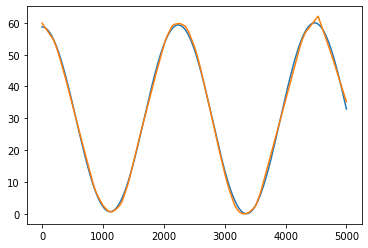

In [13]:
sc = 60
Yr_test=Y_test.numpy()
Yr_test=Yr_test*sc

pred=modelDNN(X_test.to(device)).cpu().detach().numpy()*sc

plt.plot(Yr_test)
plt.plot(pred)

R2=r2_score(Yr_test,pred)
MSE=mean_squared_error(Yr_test,pred)
MAE=mean_absolute_error(Yr_test,pred)
RMSE=np.sqrt(MSE)
CV=RMSE/np.mean(Yr_test)

print('R2',R2,'\nRMSE',RMSE,'\nMAE',MAE,'\nCV',CV)